### This example demonstrates the XCSF supervised learning mechanisms to perform regression
Classifiers are composed of tree GP conditions and neural network predictions. A single dummy action is performed such that [A] = [M].

In [1]:
from __future__ import annotations

from typing import Final

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, minmax_scale
from tqdm import tqdm

import xcsf

np.set_printoptions(suppress=True)

### Load training and test data
Loads the kin8nm dataset from: https://www.openml.org/d/189

"This is data set is concerned with the forward kinematics of an 8 link robot arm. Among the existing variants of this data set we have used the variant 8nm, which is known to be highly non-linear and medium noisy."

In [2]:
data = fetch_openml(data_id=189, as_frame=True)

data.frame.head()

,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,y
0,-0.015119,0.360741,0.469398,1.309675,0.988024,-0.025493,0.664071,0.062763,0.536524
1,0.360478,-0.301395,0.629183,-1.440146,-0.741637,-1.196749,-1.038444,-0.717461,0.308014
2,1.563238,-1.294753,0.078987,1.432937,1.149136,-1.292140,1.562988,-0.937731,0.518900
3,0.199485,0.901157,-1.356304,-0.080525,-0.976628,0.829894,-0.855649,0.930630,0.494151
4,0.659737,0.120552,-0.008756,0.648839,0.626832,-0.646539,1.318074,-0.899172,0.470218


In [3]:
data.frame.describe()

,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,y
count,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000
mean,0.009351,-0.007233,0.022792,-0.012945,0.007886,-0.009698,0.008402,0.001227,0.714283
std,0.904867,0.901496,0.900765,0.899186,0.906874,0.913243,0.909724,0.906098,0.263607
min,-1.570611,-1.570681,-1.570669,-1.570295,-1.570664,-1.570254,-1.570643,-1.568904,0.040165
25%,-0.770328,-0.778319,-0.749718,-0.780602,-0.770492,-0.802084,-0.776870,-0.777432,0.523584
50%,-0.002010,-0.015152,0.041346,-0.013617,0.009702,-0.003575,0.001338,0.002007,0.708822
75%,0.791179,0.779145,0.792391,0.760165,0.791203,0.781849,0.798014,0.780927,0.901354
max,1.570753,1.570657,1.570736,1.570169,1.570599,1.570597,1.570522,1.570237,1.458521


In [4]:
# numpy
X = np.asarray(data.data, dtype=np.float64)
y = np.asarray(data.target, dtype=np.float64)

# normalise inputs (zero mean and unit variance)
scaler = StandardScaler()
scaler.fit_transform(X)

# scale outputs [0,1]
y = minmax_scale(y, feature_range=(0, 1))

# reshape into 2D arrays
if len(np.shape(y)) == 1:
    y = y.reshape(-1, 1)

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# 10% of training for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

# get number of input and output variables
X_DIM: Final[int] = np.shape(X_train)[1]
Y_DIM: Final[int] = np.shape(y_train)[1]

print(f"X_train shape = {np.shape(X_train)}")
print(f"y_train shape = {np.shape(y_train)}")
print(f"X_val shape = {np.shape(X_val)}")
print(f"y_val shape = {np.shape(y_val)}")
print(f"X_test shape = {np.shape(X_test)}")
print(f"y_test shape = {np.shape(y_test)}")

X_train shape = (6634, 8)
y_train shape = (6634, 1)
X_val shape = (738, 8)
y_val shape = (738, 1)
X_test shape = (820, 8)
y_test shape = (820, 1)


### Initialise XCSF

In [5]:
xcs: xcsf.XCS = xcsf.XCS(x_dim=X_DIM, y_dim=Y_DIM, n_actions=1)  # supervised learning

xcs.OMP_NUM_THREADS = 12  # number of CPU cores to use
xcs.POP_SIZE = 500  # maximum population size
xcs.MAX_TRIALS = 1000  # number of trials per fit()
xcs.LOSS_FUNC = "mse"  # mean squared error
xcs.E0 = 0.005  # target error
xcs.ALPHA = 1  # accuracy offset
xcs.NU = 20  # accuracy slope
xcs.THETA_EA = 50  # EA invocation frequency
xcs.THETA_DEL = 50  # min experience before fitness used in deletion
xcs.BETA = 0.1  # update rate for error, etc.
xcs.action("integer")  # (dummy) integer actions

TREE_ARGS: Final[dict] = {
    "min_constant": 0,  # minimum value of a constant
    "max_constant": 1,  # maximum value of a constant
    "n_constants": 100,  # number of (global) constants
    "init_depth": 5,  # initial tree depth
    "max_len": 10000,  # maximum initial length
}
xcs.condition("tree_gp", TREE_ARGS)  # GP tree conditions

PREDICTION_LAYERS: Final[dict] = {
    "layer_0": {  # hidden layer
        "type": "connected",
        "activation": "relu",
        "sgd_weights": True,
        "evolve_weights": True,
        "evolve_connect": True,
        "evolve_eta": True,
        "eta": 0.1,
        "eta_min": 0.000001,
        "momentum": 0.9,
        "n_init": 10,
        "n_max": 10,
    },
    "layer_1": {  # output layer
        "type": "connected",
        "activation": "softplus",
        "sgd_weights": True,
        "evolve_weights": True,
        "evolve_connect": True,
        "evolve_eta": True,
        "eta": 0.1,
        "eta_min": 0.000001,
        "momentum": 0.9,
        "n_init": Y_DIM,
    },
}
xcs.prediction("neural", PREDICTION_LAYERS)  # neural network predictions

print(xcs.json_parameters())

{
	"version":	"1.2.7",
	"x_dim":	8,
	"y_dim":	1,
	"n_actions":	1,
	"omp_num_threads":	12,
	"pop_init":	true,
	"max_trials":	1000,
	"perf_trials":	1000,
	"pop_size":	500,
	"loss_func":	"mse",
	"set_subsumption":	false,
	"theta_sub":	100,
	"e0":	0.005,
	"alpha":	1,
	"nu":	20,
	"beta":	0.1,
	"delta":	0.1,
	"theta_del":	50,
	"init_fitness":	0.01,
	"init_error":	0,
	"m_probation":	10000,
	"stateful":	true,
	"compaction":	false,
	"ea":	{
		"select_type":	"roulette",
		"theta_ea":	50,
		"lambda":	2,
		"p_crossover":	0.8,
		"err_reduc":	1,
		"fit_reduc":	0.1,
		"subsumption":	false,
		"pred_reset":	false
	},
	"condition":	{
		"type":	"tree_gp",
		"args":	{
			"min_constant":	0,
			"max_constant":	1,
			"n_constants":	100,
			"init_depth":	5,
			"max_len":	10000
		}
	},
	"prediction":	{
		"type":	"neural",
		"args":	{
			"layer_0":	{
				"type":	"connected",
				"activation":	"relu",
				"n_inputs":	8,
				"n_init":	10,
				"evolve_weights":	true,
				"evolve_functions":	false,
				"evolve_conn

### Run experiment

In [6]:
N: Final[int] = 200  # 200,000 trials
trials: np.ndarray = np.zeros(N)
psize: np.ndarray = np.zeros(N)
msize: np.ndarray = np.zeros(N)
train_mse: np.ndarray = np.zeros(N)
val_mse: np.ndarray = np.zeros(N)

VAL_PERIOD: Final[int] = 10  # validation mean moving average length
val_min: float = 999999  # minimum validation error
val_trial: int = 0  # trial number the system was checkpointed

bar = tqdm(total=N)  # progress bar
for i in range(N):
    # train
    train_mse[i] = xcs.fit(X_train, y_train, shuffle=True)
    trials[i] = xcs.time()  # number of trials so far
    psize[i] = xcs.pset_size()  # current population size
    msize[i] = xcs.mset_size()  # avg match set size
    # validate
    val_mse[i] = xcs.score(X_val, y_val)
    if i > VAL_PERIOD:  # simple moving average of mean validation error
        val_mean = np.mean(val_mse[i - VAL_PERIOD : i])
        if val_mean < val_min:  # checkpoint lowest validation error
            xcs.store()
            val_min = val_mean
            val_trial = trials[i]
    status = (  # update status
        f"trials={trials[i]:.0f} "
        f"train_mse={train_mse[i]:.5f} "
        f"val_mse={val_mse[i]:.5f} "
        f"psize={psize[i]:.1f} "
        f"msize={msize[i]:.1f}"
    )
    bar.set_description(status)
    bar.refresh()
    bar.update(1)
bar.close()

trials=200000 train_mse=0.00453 val_mse=0.00453 psize=500.0 msize=295.6: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.60it/s]


### Plot XCSF learning performance

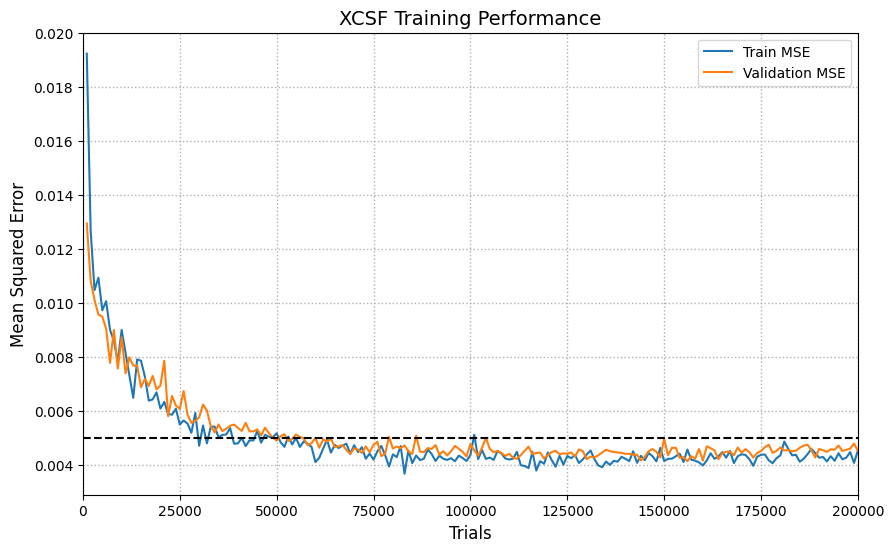

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(trials, train_mse, label="Train MSE")
plt.plot(trials, val_mse, label="Validation MSE")
plt.grid(linestyle="dotted", linewidth=1)
plt.axhline(y=xcs.E0, xmin=0, xmax=1, linestyle="dashed", color="k")
plt.title("XCSF Training Performance", fontsize=14)
plt.xlabel("Trials", fontsize=12)
plt.ylabel("Mean Squared Error", fontsize=12)
plt.xlim([0, N * xcs.MAX_TRIALS])
plt.legend()
plt.show()

### Compare with alternatives

In [8]:
# final XCSF test score
print(f"Restoring system from trial {val_trial:.0f} with val_mse={val_min:.5f}")
xcs.retrieve()
xcsf_pred = xcs.predict(X_test)
xcsf_mse = mean_squared_error(xcsf_pred, y_test)
print(f"XCSF Test MSE = {xcsf_mse:.4f}")

# compare with linear regression
lm = LinearRegression()
lm.fit(X_train, y_train)
lm_pred = lm.predict(X_test)
lm_mse = mean_squared_error(lm_pred, y_test)
print(f"Linear regression Test MSE = {lm_mse:.4f}")

# compare with MLP regressor
X_train = np.vstack((X_train, X_val))
y_train = np.vstack((y_train, y_val))
mlp = MLPRegressor(
    hidden_layer_sizes=(10,),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init=0.01,
    max_iter=1000,
    alpha=0.01,
    validation_fraction=0.1,
)
mlp.fit(X_train, y_train.ravel())
mlp_pred = mlp.predict(X_test)
mlp_mse = mean_squared_error(mlp_pred, y_test)
print(f"MLP Regressor Test MSE = {mlp_mse:.4f}")

Restoring system from trial 161000 with val_mse=0.00436
XCSF Test MSE = 0.0044
Linear regression Test MSE = 0.0195
MLP Regressor Test MSE = 0.0076


### Show some predictions vs. answers

In [9]:
pred = xcs.predict(X_test[:10])

print("first 10 predictions = ")
print(pred)

first 10 predictions = 
[[0.29963849]
 [0.36671144]
 [0.58278953]
 [0.45574751]
 [0.29490427]
 [0.47439174]
 [0.38845417]
 [0.44229322]
 [0.8635223 ]
 [0.34847859]]


In [10]:
print("first 10 answers = ")
print(y_test[:10])

first 10 answers = 
[[0.20123213]
 [0.24044461]
 [0.44367659]
 [0.41833523]
 [0.24673845]
 [0.42149893]
 [0.51209794]
 [0.38717895]
 [0.83619625]
 [0.24462412]]


### Visualise the lowest error rule in the population set

Condition (matches when output node > 0.5):


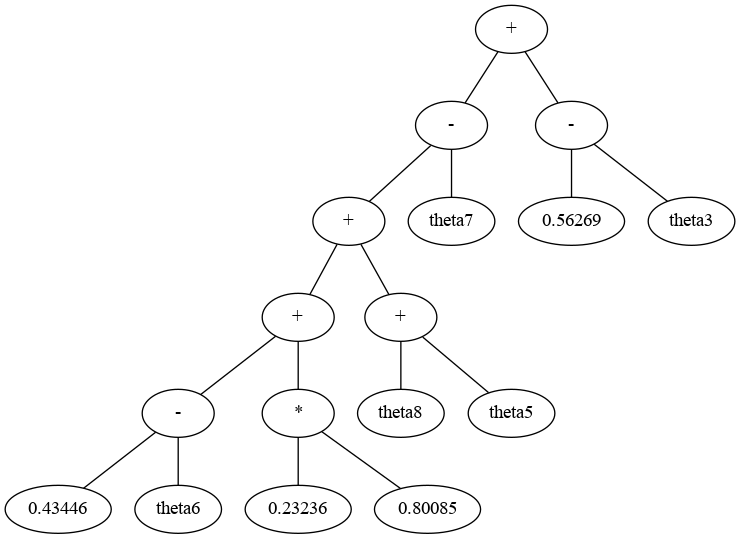

In [11]:
import json
import graphviz
from IPython.display import display, Image
from xcsf.utils.viz import TreeViz

print("Condition (matches when output node > 0.5):")
parsed = json.loads(xcs.json())
parsed = sorted(  # sort population by error
    parsed["classifiers"], key=lambda d: d["error"]
)
trees = [cl["condition"]["tree"]["array"] for cl in parsed]
TreeViz(trees[0], "best", feature_names=data.feature_names)
with open("best.gv") as f:
    dot = f.read()
    tree = graphviz.Source(dot)
    tree.format = "png"
    tree.render("best")
    display(Image("best.png"))

In [12]:
def print_attributes(cl: dict) -> None:
    """Prints a classifier's attributes."""
    print(f"Error: {cl['error']:.5f}")
    print(f"Fitness: {cl['fitness']:.5f}")
    print(f"Accuracy: {cl['accuracy']:.5f}")
    print(f"Average Set Size: {cl['set_size']:.2f}")
    print(f"Numerosity: {cl['numerosity']}")
    print(f"Experience: {cl['experience']}")
    print(f"Samples Seen: {cl['samples_seen']}")
    print(f"Samples Matched: {cl['samples_matched']}")


print_attributes(parsed[0])

Error: 0.00203
Fitness: 0.00608
Accuracy: 1.00000
Average Set Size: 298.92
Numerosity: 1
Experience: 4285
Samples Seen: 13740
Samples Matched: 8623
